In [ ]:
import pandas as pd
import numpy as np 
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from sklearn.model_selection import train_test_split
import re
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def tokenize_text(text):
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    text = text.split()
    text = [ word for word in text if not word in STOP_WORDS and len(word)>2]
    text = ' '.join(text)
    return text

In [ ]:
#/content/drive/My Drive/Colab Notebooks/glove.zip
#/content/drive/My Drive/Colab Notebooks/data50.zip
import zipfile
from google.colab import drive
!unzip /content/drive/"My Drive"/"Colab Notebooks"/glove.zip
!unzip /content/drive/"My Drive"/"Colab Notebooks"/data50.zip

Archive:  /content/drive/My Drive/Colab Notebooks/glove.zip
  inflating: glove_title.txt         


In [ ]:
!unzip /content/drive/"My Drive"/"Colab Notebooks"/gbody.zip

Archive:  /content/drive/My Drive/Colab Notebooks/gbody.zip
  inflating: glove_body.txt          


In [ ]:
!unzip /content/drive/"My Drive"/"Colab Notebooks"/data50.zip

Archive:  /content/drive/My Drive/Colab Notebooks/data50.zip
  inflating: sample50k.csv           


In [ ]:
VEC_DIM = 300
max_len = 512
df = pd.read_csv('sample50k.csv')
df = df[['body','label']]
df = df[pd.notnull(df['body'])]

In [ ]:
n = df.shape
print(n)

df.index = range(n[0])
X  = df['body']
Y = df['label']
X = X.apply(lambda x: tokenize_text(x))
X_train, X_test , Y_train, Y_test = train_test_split(X, Y , test_size = 0.20,stratify=df['label'])

(50000, 2)


In [ ]:
embed = {}
def load_embed():
    with open('glove_body.txt','r') as f:
        for l in f:
            l = l.split()
            try:			
            	embed[l[0]] = np.asarray(l[1:], dtype = 'float32')
            except:
            	pass
load_embed()
len(embed)

107223

In [ ]:
def get_embedding_matrix(features, vec_dim):
    embedding_matrix = np.zeros((features+1, vec_dim))
    for word, index in tokenizer.word_index.items():
        try:
            embedding_matrix[index] = embed[word]
        except:
            pass
    return embedding_matrix

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
max_features = len(tokenizer.word_counts)
embedding_matrix = get_embedding_matrix(max_features, VEC_DIM)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test , maxlen=max_len)

In [ ]:
inp1 = Input(shape=(max_len,))
x = Embedding(embedding_matrix.shape[0], VEC_DIM, weights=[embedding_matrix])(inp1)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)    
model = Model(inputs=inp1, outputs=x)

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
model.fit(X_train,Y_train, batch_size=256, epochs=2)

Epoch 1/2
157/157 [==============================] - 3427s 22s/step - loss: -5.9573
Epoch 2/2
157/157 [==============================] - 3399s 22s/step - loss: -6.5799


In [ ]:
model.summary()

In [ ]:

Y_pred = model.predict(X_test)
cp = [x for x in Y_pred]
# print(Y_pred)
Y_pred = [2 if sum(x)/512>0.99 else 0 for x in Y_pred]
# Y_test = Y_test.to_numpy()
#for i in range(len(Y_pred)):
#	print(Y_pred[i],Y_test[i])
print(accuracy_score(Y_test,Y_pred))
print(f1_score(Y_test,Y_pred,average='macro'))
print(f1_score(Y_test,Y_pred,average='weighted'))
print(f1_score(Y_test,Y_pred,average='micro'))

0.7587
0.6098289535730572
0.7062324157242262
0.7587


In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        print(j,i,cm[i,j])
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
0 0 705
1 0 2295
0 1 118
1 1 6882


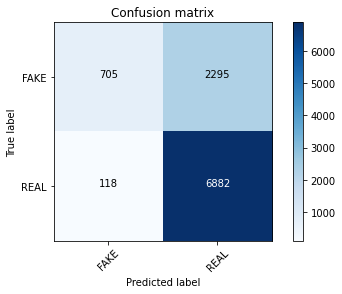

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

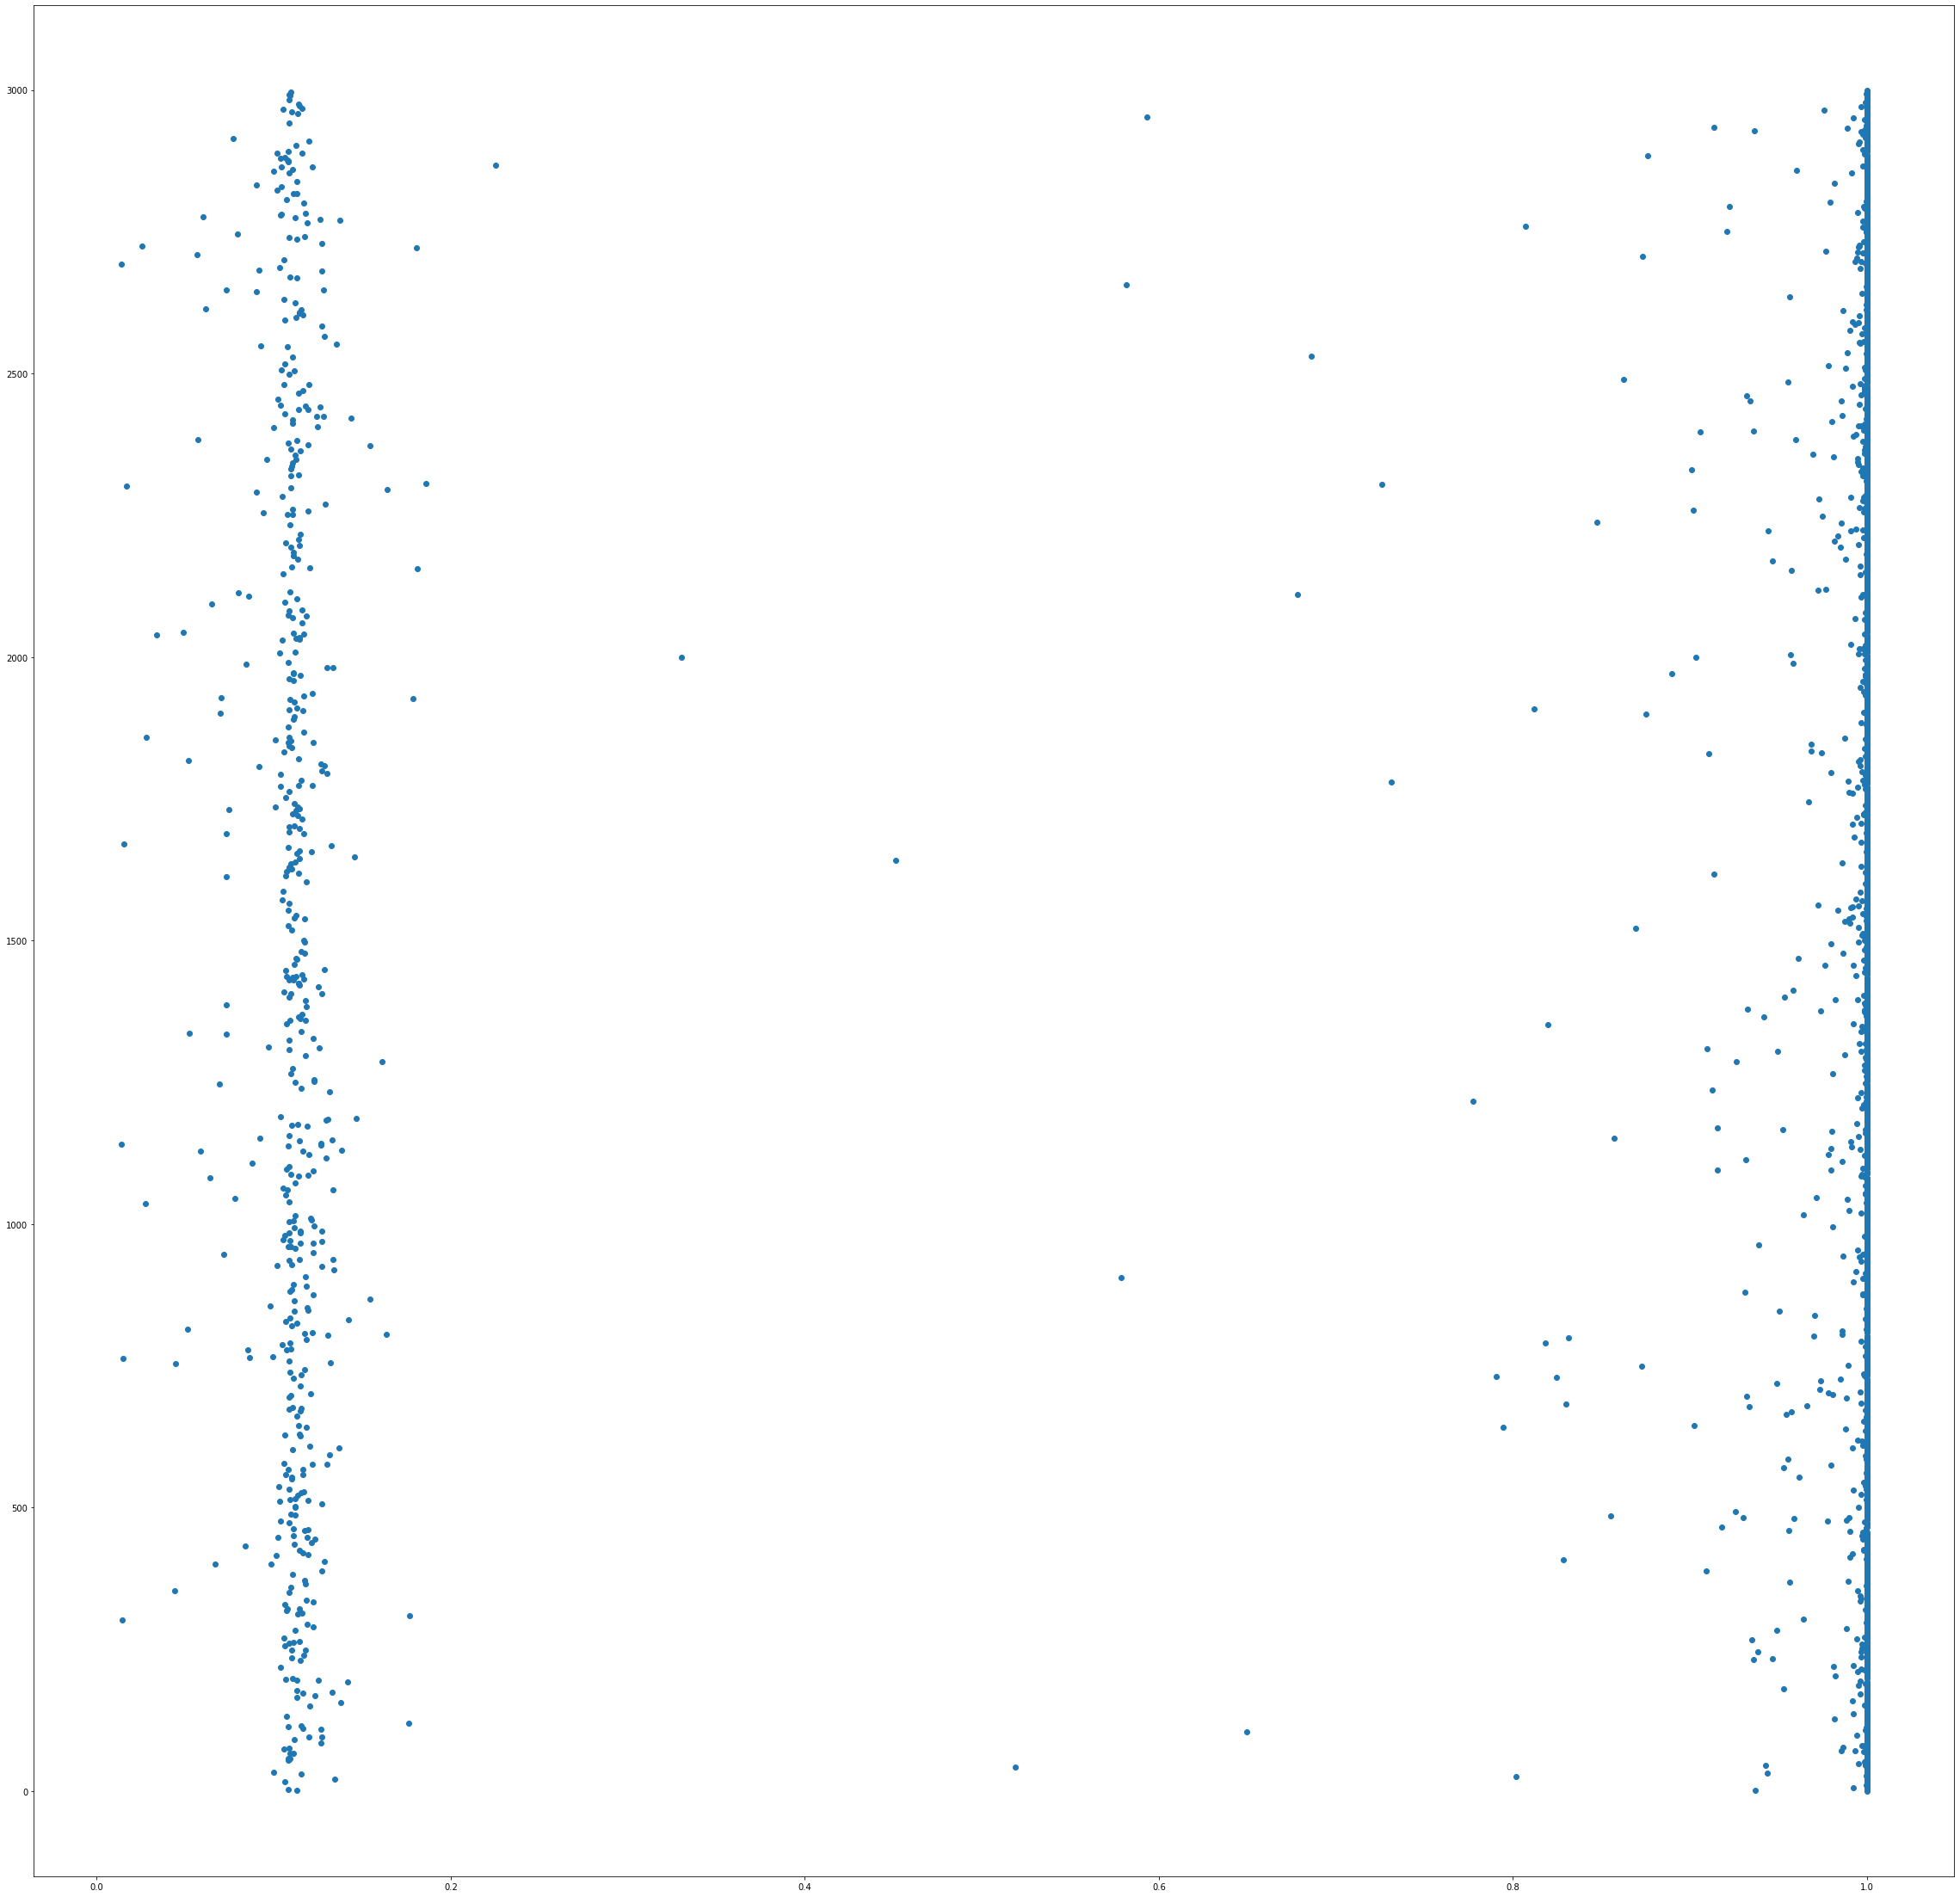

In [ ]:
import matplotlib.pyplot as plt
Y_test = [x for x in Y_test]
n = len(cp)
dd = []
for i in range(0,n):
  if(Y_test[i]==0):
    dd.append(sum(cp[i])/512)
n = len(dd)
plt.figure(figsize=(40,40))
plt.scatter(dd,range(0,n))
# plt.scatter(range(0,n),Y_test)

plt.show()


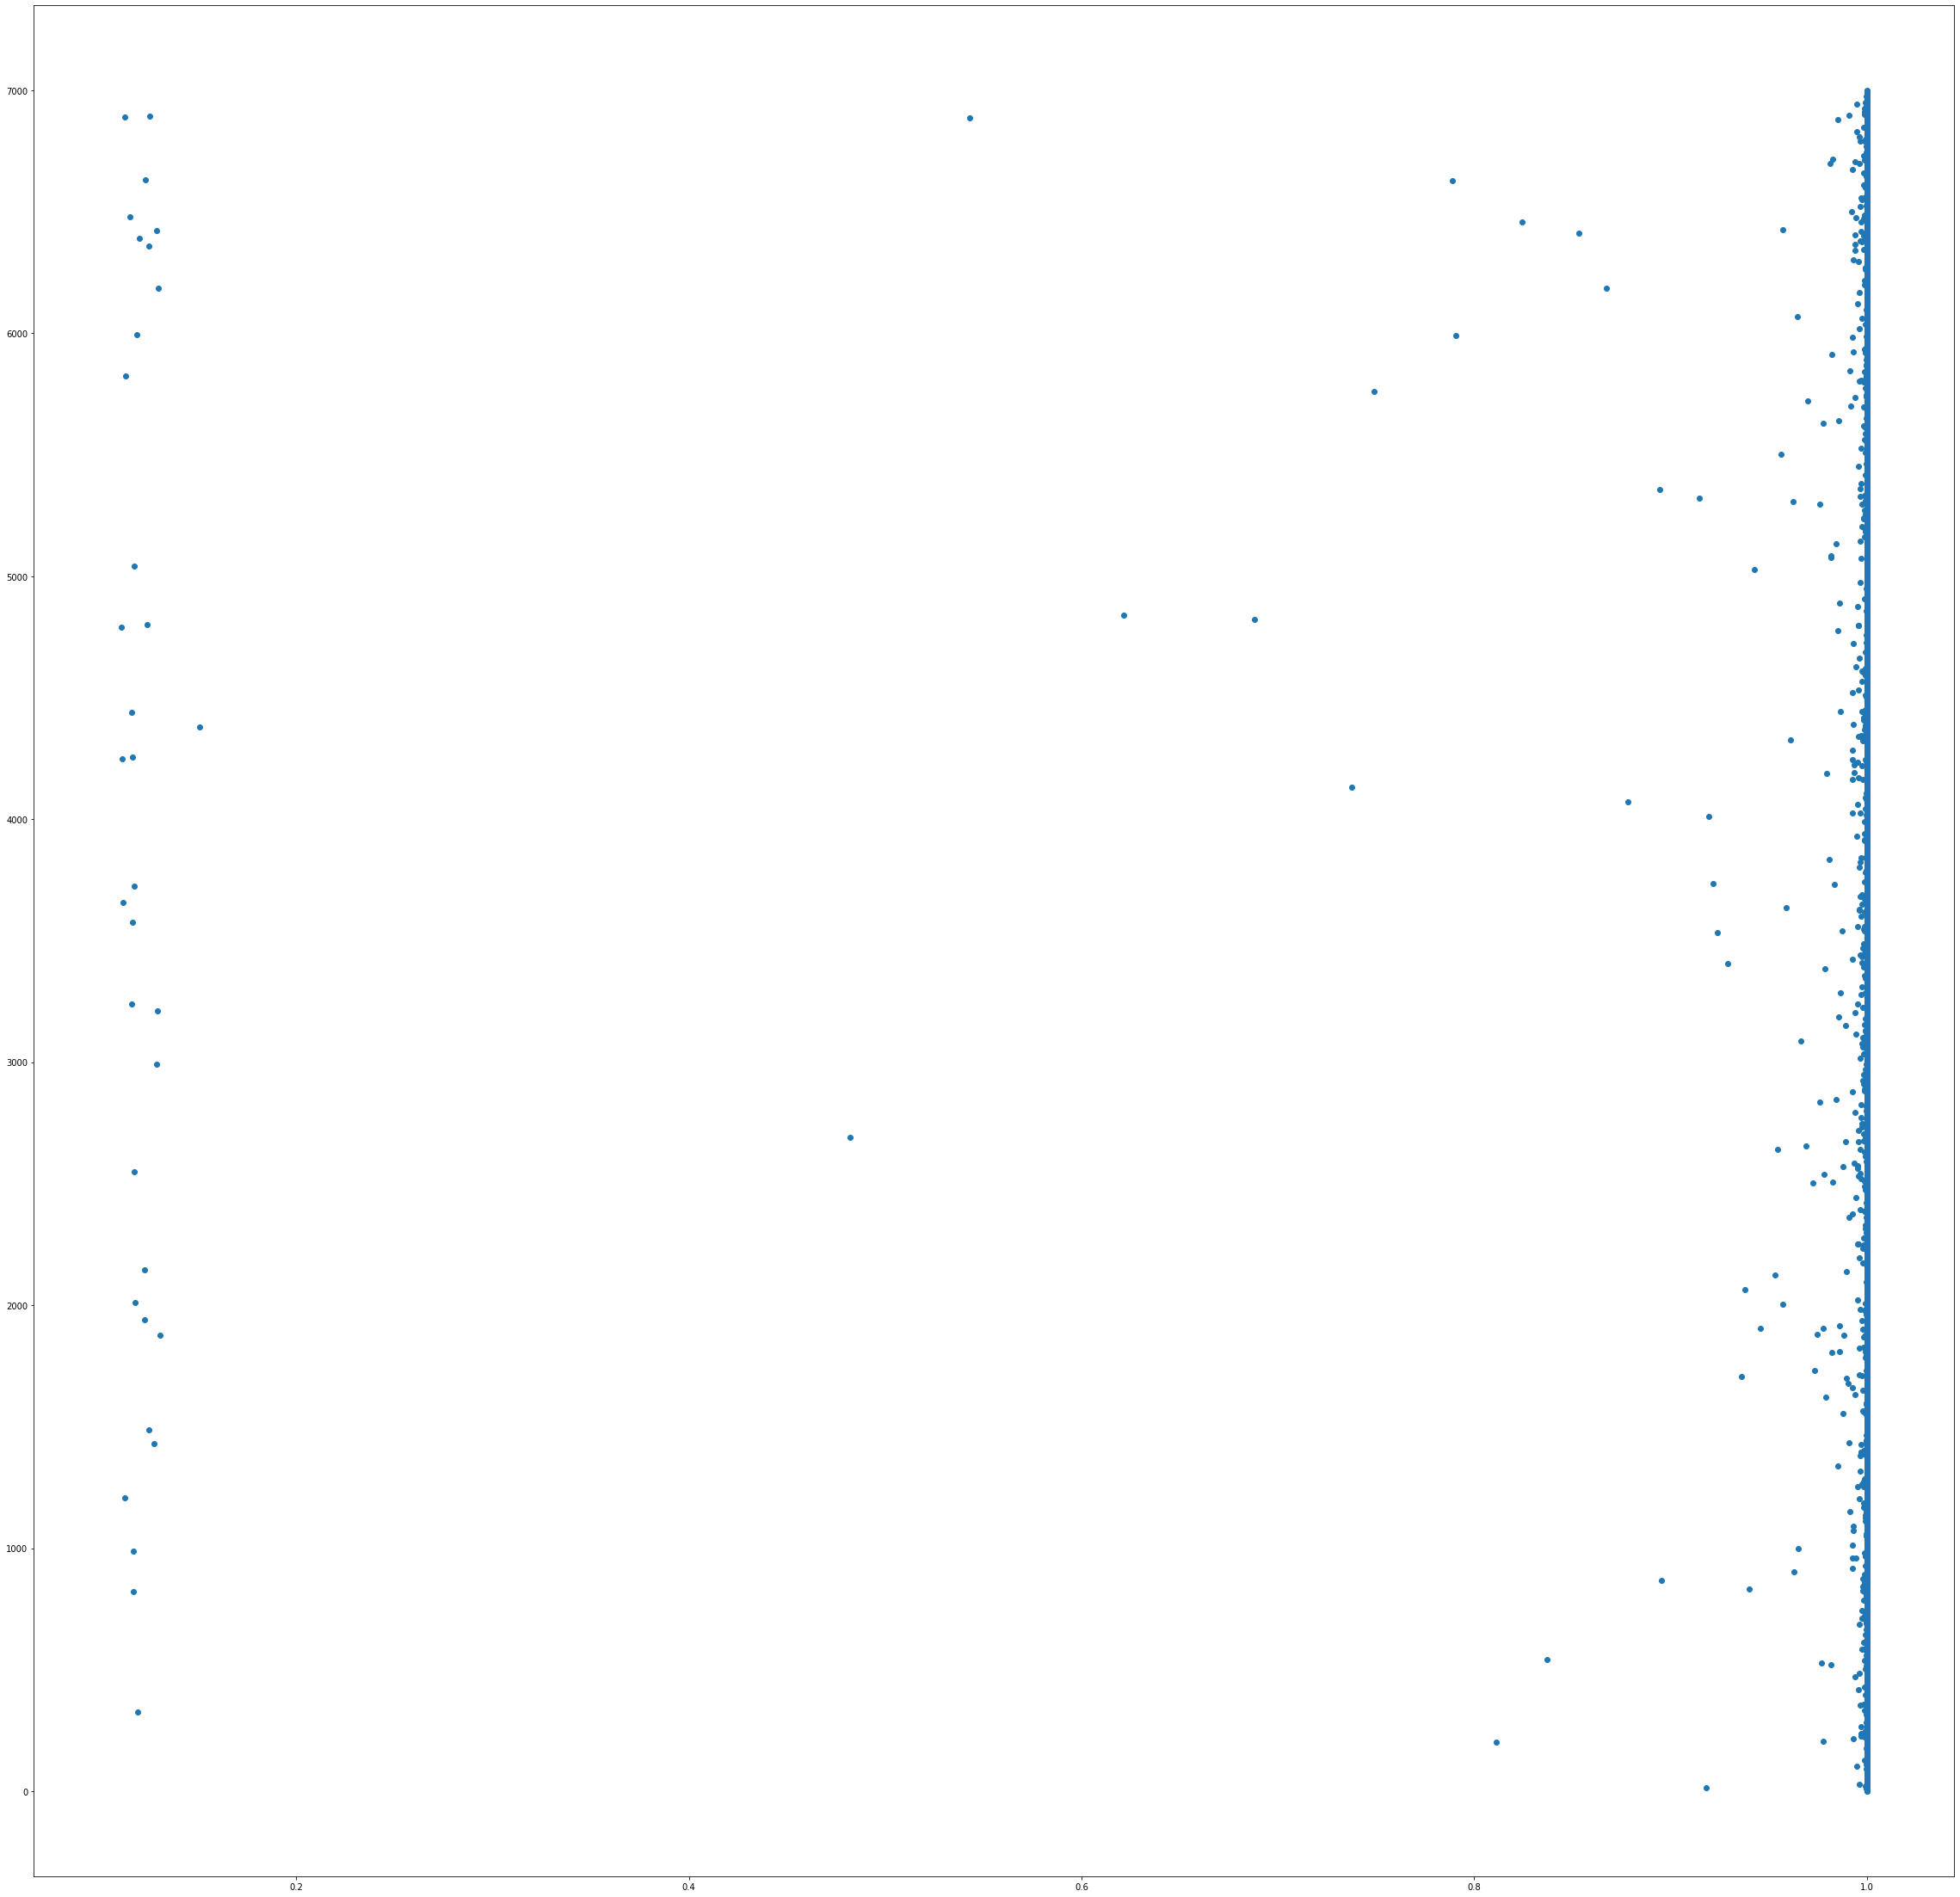

In [ ]:
import matplotlib.pyplot as plt
# Y_test = [x for x in Y_test]
n = len(cp)
dd = []
for i in range(0,n):
  if(Y_test[i]==2):
    dd.append(sum(cp[i])/512)
n = len(dd)
plt.figure(figsize=(40,40))
plt.scatter(dd,range(0,n))
# plt.scatter(range(0,n),Y_test)

plt.show()